In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.filters import threshold_otsu
from skimage.measure import label
from uncertainties import ufloat
import uncertainties as ct
from uncertainties import unumpy as unp
from scipy.optimize import curve_fit
import importlib
import sys

sys.path.append('C:\\Users\\marcu\\OneDrive\\Desktop\\PraktikumIII\\CapillaryRiseInSoil\\notebooks')

import amglib.imageutils as amg
import amglib.readers as rd
import amglib.bb as bblib

import os

os.chdir('C:\\Users\\marcu\\OneDrive\\Desktop\\PraktikumIII\\CapillaryRiseInSoil')

In [2]:
"""
ob: open beam
dc: dark current
es: empty step wedge

"""
ob = rd.readImages('data/02_rawdata/01_Stepwedges/ob_{0:05d}.fits',first=1,last=11).astype(float).mean(axis=0)
dc = rd.readImages('data/02_rawdata/01_Stepwedges/dc_{0:05d}.fits',first=1,last=11).astype(float).mean(axis=0)
es = rd.readImages('data/02_rawdata/01_Stepwedges/container_{0:05d}.fits',first=1,last=6).astype(float).mean(axis=0) 
bb = rd.readImages('data/02_rawdata/01_Stepwedges/bb_{0:05d}.fits',first=1,last=6).astype(float).mean(axis=0)
bbes = rd.readImages('data/02_rawdata/01_Stepwedges/water_bb_{0:05d}.fits',first=1,last=6).astype(float).mean(axis=0)
water = rd.readImages('data/02_rawdata/01_Stepwedges/water_{0:05d}.fits',first=1,last=6).astype(float).mean(axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
ob = ob[::-1]
dc = dc[::-1]
es = es[::-1]
bb = bb[::-1]
bbes = bbes[::-1]
water = water[::-1]

##### BB correction 

Text(0.5, 1.0, 'Black body and containers, histogram')

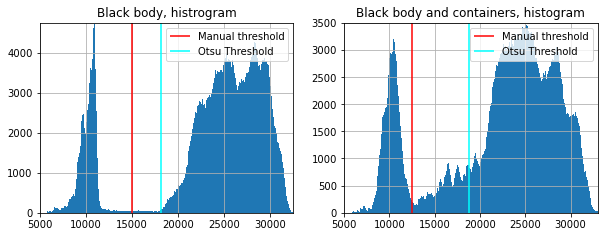

In [16]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 3.5)
ax[0].hist(bb.ravel(), bins=1000);
ax[0].set_xlim(5000, 32500)
ax[0].set_ylim(0, 4750)
ax[0].vlines([15000], ymax=5000, ymin=0, color='r', label="Manual threshold")
ax[0].vlines([threshold_otsu(bb.ravel())], ymax=5000 ,ymin=0,color='cyan', label = "Otsu Threshold")
ax[0].grid()
ax[0].legend(loc="upper right")
ax[0].set_title("Black body, histrogram")

ax[1].hist(bbes.ravel(), bins=1000);
ax[1].set_xlim(5000, 33000)
ax[1].set_ylim(0, 3500)
ax[1].vlines([12500], ymax=5000, ymin=0, color='r', label="Manual threshold")
ax[1].vlines([threshold_otsu(bbes.ravel())], ymax=5000 ,ymin=0,color='cyan', label = "Otsu Threshold")
ax[1].grid()
ax[1].legend(loc="upper right")
ax[1].set_title("Black body and containers, histogram")

# fig.savefig("BB_Histograms")

Text(0.5, 1.0, 'BB: open beam and empty step wedges')

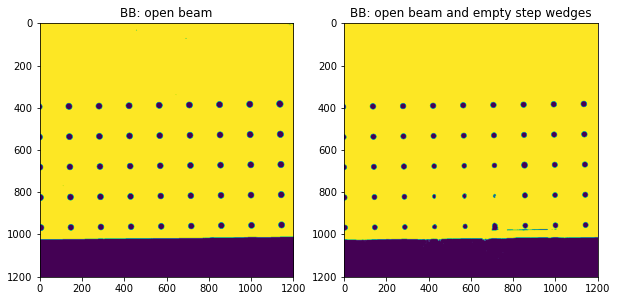

In [14]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
ax[0].imshow(18000<bb)
ax[0].set_title("BB: open beam")
ax[1].imshow(12500<bbes)
ax[1].set_title("BB: open beam and empty step wedges")
# fig.savefig("BB_BBs_found")

In [9]:
maskbb, rbb, cbb = bblib.get_black_bodies(bb, greythres=15000, areas=[0, 1000] , R=9)
maskbbes,rbbes,cbbes = bblib.get_black_bodies(bbes, greythres=12500, areas=[0, 1000], R=9)

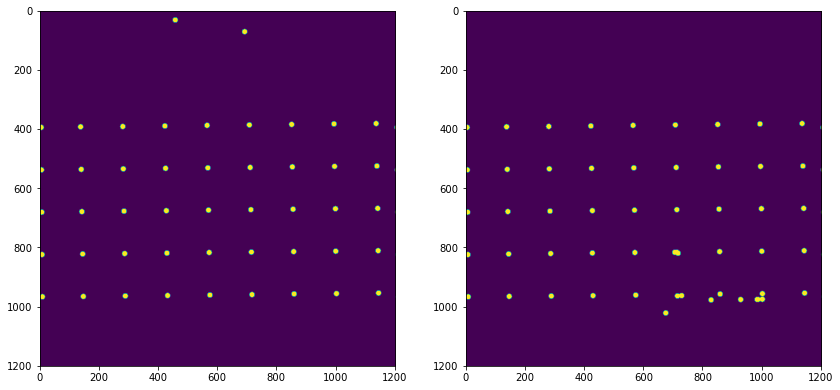

In [12]:
fig,ax = plt.subplots(1,2,figsize=[14,10])
ax[0].imshow(maskbb)
ax[1].imshow(maskbbes)

In [13]:
img_corr_bb = bblib.compute_scatter_image(bb, rbb, cbb)
img_corr_bbes = bblib.compute_scatter_image(bbes, rbbes, cbbes)

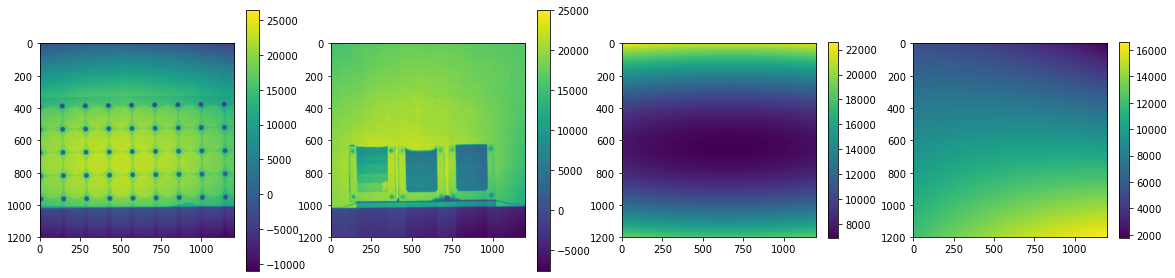

In [25]:
fig,ax = plt.subplots(1,4,figsize=[20,12])
a0=ax[0].imshow(bb - img_corr_bb - dc)

fig.colorbar(a0,ax=ax[0],shrink=0.4);

a1=ax[1].imshow(water - img_corr_bbes - dc)

fig.colorbar(a1,ax=ax[1],shrink=0.4);

img1 = bb - img_corr_bb - dc
img2 = water - img_corr_bbes - dc

a2 = ax[2].imshow(img_corr_bb)
fig.colorbar(a2,ax=ax[2],shrink=0.3);
a3 = ax[3].imshow(img_corr_bbes)
fig.colorbar(a3,ax=ax[3],shrink=0.3);

### Beer Lambert normalization 

In [31]:
D0 = (bb - dc - img_corr_bb)[0:200, :].mean()
D =  (water - dc - img_corr_bbes)[0:200, :].mean()


temp2 = (water - dc - img_corr_bbes) / (bbes - dc - img_corr_bb)
temp2[temp2 < 1] = 1

p = -np.log(D0/D * temp2)

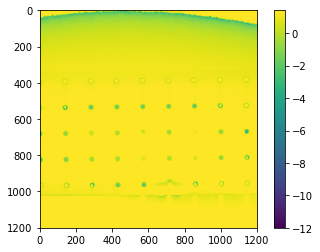

In [32]:
plt.imshow(p)
plt.colorbar()

##### Trying to find another  way to do it -> abs(img) instead of setting everything equal to 1 

In [33]:
temp2 = (water - dc - img_corr_bbes) / (bbes - dc - img_corr_bb)
temp2 = abs(temp2)
p = -np.log(D0/D * temp2)

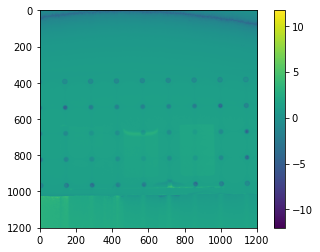

In [34]:
plt.imshow(p)
plt.colorbar()

##### Trying to start the analysis 

In [37]:
step_wedge_1 = p[:, 200:250]
stw1_average = step_wedge_1.mean(axis=1)

step_wedge_2 = p[:, 500:550]
stw2_average = step_wedge_2.mean(axis=1)

step_wedge_3 = p[:, 800:850]
stw3_average = step_wedge_3.mean(axis=1)

d1 = (stw1_average[:-1] - stw1_average[1:])
d2 = (stw2_average[:-1] - stw2_average[1:])
d3 = (stw3_average[:-1] - stw3_average[1:])

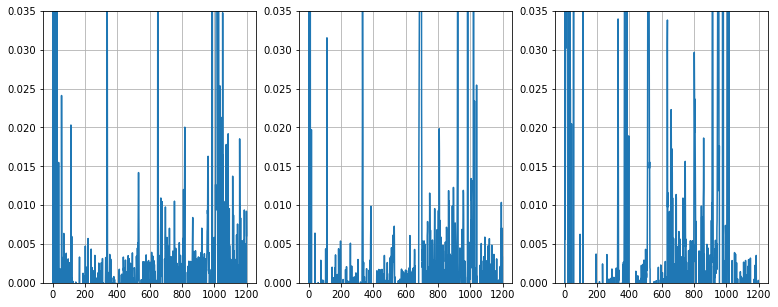

In [38]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(13,5)
ax[0].plot(d1)
ax[0].set_ylim(0, 0.035)
ax[1].plot(d2)
ax[1].set_ylim(0, 0.035)
ax[2].plot(d3)
ax[2].set_ylim(0, 0.035)
for axis in ax:
    axis.grid()

In [39]:
l1 = (d1<0.02)
l2 = (d2<0.025)
l3 = (d3<0.03)

In [40]:
s_stw1 = step_wedge_1.mean(axis=1)[1:]
masked_1 = s_stw1[l1 == 0]

s_stw2 = step_wedge_2.mean(axis=1)[1:]
masked_2 = s_stw2[l2 == 0]

s_stw3 = step_wedge_3.mean(axis=1)[1:]
masked_3 = s_stw3[l3 == 0]

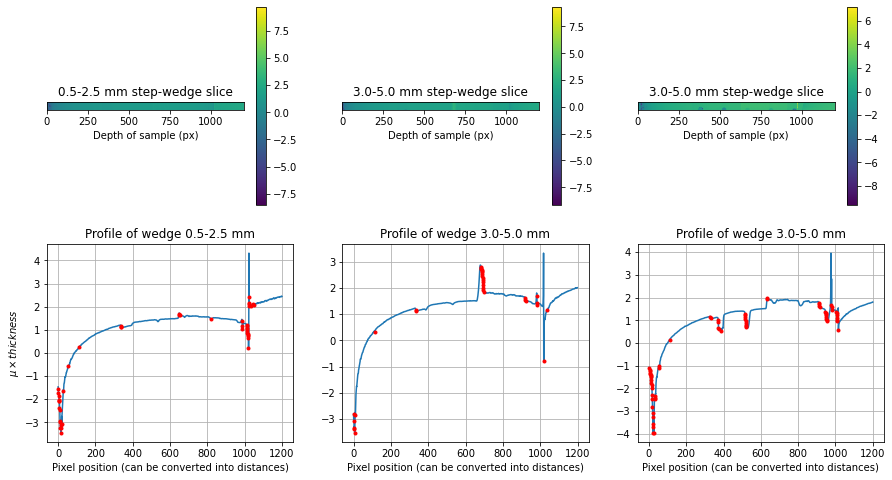

In [41]:
fig, ax = plt.subplots(2, 3)
# fig.set_size_inches(18, 10)
fig.set_size_inches(15, 8)
# fig.set_dpi(800)
ax = ax.ravel()

ax[0].imshow(np.transpose(step_wedge_1))
ax[0].tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False
) # labels along the bottom edge are off
ax[0].set_title("0.5-2.5 mm step-wedge slice")
ax[0].set_xlabel("Depth of sample (px)")

ax[1].imshow(np.transpose(step_wedge_2), interpolation = 'none')
ax[1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 
ax[1].set_title("3.0-5.0 mm step-wedge slice")
ax[1].set_xlabel("Depth of sample (px)")

ax[2].imshow(np.transpose(step_wedge_3), interpolation = 'none')
ax[2].tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 
ax[2].set_title("3.0-5.0 mm step-wedge slice")
ax[2].set_xlabel("Depth of sample (px)")

ax[3].plot(step_wedge_1.mean(axis=1))
ax[3].set_title('Profile of wedge 0.5-2.5 mm')
ax[3].set_xlabel('Pixel position (can be converted into distances)')
ax[3].plot(np.where(l1 == 0)[0], masked_1, 'r.')
# ax[3].set_xlim(150, 450)
# ax[3].set_ylim(0, 0.5)
ax[3].set_ylabel(r'$\mu\times thickness$')
ax[3].grid()

ax[4].plot(s_stw2)
ax[4].set_title('Profile of wedge 3.0-5.0 mm')
ax[4].set_xlabel('Pixel position (can be converted into distances)')
ax[4].plot(np.where(l2 == 0)[0], masked_2, 'r.')
# ax[4].set_xlim(150, 450)
# ax[4].set_ylim(0, 0.7)
ax[4].grid()

ax[5].plot(step_wedge_3.mean(axis=1))
ax[5].set_title('Profile of wedge 3.0-5.0 mm')
ax[5].set_xlabel('Pixel position (can be converted into distances)')
ax[5].plot(np.where(l3 == 0)[0], masked_3, 'r.')
# ax[5].set_xlim(120, 450)
# ax[5].set_ylim(0,0.7)
ax[5].grid()

for (axis, wedge) in zip(ax, [step_wedge_1, step_wedge_2, step_wedge_3]):
    pcm = axis.pcolormesh(np.transpose(wedge))
    fig.colorbar(pcm, ax=axis, shrink=1)